<a href="https://colab.research.google.com/github/nunocesarsa/SENSECO_School_2021/blob/main/ColabNotebooks/SENSECO_06_PredictionsImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting up

## AutoSklearn

In [ ]:
#source: https://colab.research.google.com/github/vopani/fortyone/blob/main/notebooks/automl/tabular/Auto-Sklearn.ipynb#scrollTo=yFSo4OV0FOZN

!python3 -m pip install --upgrade pip
!pip3 install scikit-learn==0.24.1
!pip3 install pandas

!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip3 install
!pip3 install auto-sklearn

!pip install PipelineProfiler
#NOTICE: you might be required to restart runtime before proceeding - Ctrl + M


## Restart runtime!!

In [ ]:
#quick test - if needed
from autosklearn.classification import AutoSklearnClassifier
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer(as_frame=True)['data']
target = load_breast_cancer(as_frame=True)['target']

sklearn_aml = AutoSklearnClassifier(time_left_for_this_task=30)
sklearn_aml.fit(X=data, y=target)

import PipelineProfiler
prof_data = PipelineProfiler.import_autosklearn(sklearn_aml)
PipelineProfiler.plot_pipeline_matrix(prof_data)

## GDrive

In [2]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing packages

In [ ]:
#Installing PROSAIL
!pip install prosail

#latin hypercube stuff
!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
!pip install pysptools

#geographic stuff related packages
!pip install rasterio
#!pip install geopandas
!pip install earthpy
#!pip install rasterstats

!pip install pyrsgis


## Importing Packages

In [4]:
#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os
from glob import glob

#for saving model data
import pickle #for storing data
import joblib

#the beutiful R like data frame
import pandas as pd
import geopandas as gpd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#a few more stuff for random
import random as rdm
import math

#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance

## AutoML
import autosklearn
from autosklearn.regression import AutoSklearnRegressor
import PipelineProfiler


## Scikit learn metrics stuff
import sklearn.metrics

## Geoinformation stuff
from pyrsgis.convert import changeDimension
from pyrsgis import raster

#raster plotting
import earthpy.plot as ep



#Step 1: Load the saved models



In [5]:
AutoRTM_0030 =joblib.load('/content/drive/MyDrive/SENSECO/Models/AutoRTM_0030.pkl')
AutoRTM_0300 =joblib.load('/content/drive/MyDrive/SENSECO/Models/AutoRTM_0300.pkl')

## "Special" model:

If we try: 

```
AutoRTM_rest =joblib.load('/content/drive/MyDrive/SENSECO/Models/AutoRTM_Restricted.pkl')
```
It causes the following error:

```
AttributeError: module '__main__' has no attribute 'GaussianProcess2'
```

This is because the model does not exist in the vanilla AutoSklearn. We have to re-add it first



In [6]:
from ConfigSpace.configuration_space import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter

from autosklearn.pipeline.components.base import AutoSklearnRegressionAlgorithm
from autosklearn.pipeline.constants import DENSE, UNSIGNED_DATA, PREDICTIONS

#creating the class
class GaussianProcess2(AutoSklearnRegressionAlgorithm):
    def __init__(self, alpha, thetaL, thetaU, random_state=None):
        self.alpha = alpha
        self.thetaL = thetaL
        self.thetaU = thetaU
        # We ignore it
        self.random_state = random_state
        self.estimator = None
        self.scaler = None

    def fit(self, X, y):
        import sklearn.gaussian_process

        self.alpha = float(self.alpha)
        self.thetaL = float(self.thetaL)
        self.thetaU = float(self.thetaU)

        n_features = X.shape[1] 
        kernel = sklearn.gaussian_process.kernels.RBF( #here we could change the kernel parameters - notice also that deeper changes are needed to allow for kernel search
            length_scale=[1.0]*n_features,
            length_scale_bounds=[(self.thetaL, self.thetaU)]*n_features)

        # Instanciate a Gaussian Process model
        self.estimator = sklearn.gaussian_process.GaussianProcessRegressor(
            kernel=kernel,
            n_restarts_optimizer=10,
            optimizer='fmin_l_bfgs_b',
            alpha=self.alpha,
            copy_X_train=True,
            random_state=self.random_state,
            normalize_y=True)

        self.estimator.fit(X, y)
        return self

    def predict(self, X):
        if self.estimator is None:
            raise NotImplementedError
        return self.estimator.predict(X)

    @staticmethod
    def get_properties(dataset_properties=None):
        return {'shortname': 'GP',
                'name': 'Gaussian Process',
                'handles_regression': True,
                'handles_classification': False,
                'handles_multiclass': False,
                'handles_multilabel': False,
                'handles_multioutput': True,
                'is_deterministic': True,
                'input': (DENSE, UNSIGNED_DATA),
                'output': (PREDICTIONS,)}

    @staticmethod
    def get_hyperparameter_search_space(dataset_properties=None):
        alpha = UniformFloatHyperparameter(
            name="alpha", lower=0.05, upper=1.0, default_value=0.05, log=True) #here we want to force a mininum noise value
        thetaL = UniformFloatHyperparameter(
            name="thetaL", lower=1e-10, upper=1e-3, default_value=1e-6, log=True)
        thetaU = UniformFloatHyperparameter(
            name="thetaU", lower=1.0, upper=100000, default_value=100000.0, log=True)

        cs = ConfigurationSpace()
        cs.add_hyperparameters([alpha, thetaL, thetaU])
        return cs

#adding it to the pipeline
autosklearn.pipeline.components.regression.add_regressor(GaussianProcess2)

#loading the model 
AutoRTM_rest =joblib.load('/content/drive/MyDrive/SENSECO/Models/AutoRTM_Restricted.pkl')

### Confirming

In [ ]:
loaded_mdl_pipeline = PipelineProfiler.import_autosklearn(AutoRTM_rest)
PipelineProfiler.plot_pipeline_matrix(loaded_mdl_pipeline)

#Step 2: Loading raster data

## Details

The band order was set already when downloading from GEE:

```
#this command creates an object which is already filtered to the aoi
s2_collection = (ee.ImageCollection("COPERNICUS/S2_SR") #selects the L8 Surface reflectance product in GEE
                 .select(['B2','B3','B4',#'B8A'
                          'B5','B6','B7',
                          'B8A','B11','B12'
                          ]) #selects the bands of interest
                 .filter(ee.Filter.date('2016-01-01','2020-03-01')) #filters on the time - you can play around with this to select different dates..
                 .filterBounds(CLBJ_gee) #filters on the Aoi we have created above
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',5))
                 .filter(ee.Filter.inList('MGRS_TILE', tilelist)))
```

Thus:
B2, B3, ... B8A, B11, B12



## Example in one image

In [ ]:
ds1, bands = raster.read('/content/drive/MyDrive/SENSECO_S2Data/S2A_MSIL2A_20190321_T14SPC.tif')

print(ds1)
print(bands.shape)

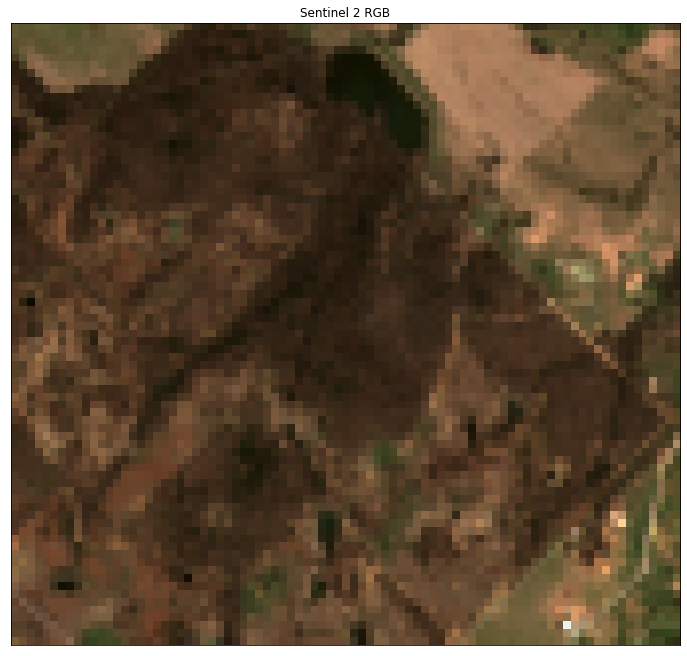

In [9]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot red, green, and blue bands, respectively
ep.plot_rgb(bands, rgb=(2,1,0), ax=ax, title="Sentinel 2 RGB")
plt.show()

### Applying AutoSklearn

Autosklearn expects data inputed as a table, so we must transform the raster into a table.

In this table, the rows represent each pixel while the columns represent each feature (band). 



### Spectral data prep

In [ ]:
bandByPixel = changeDimension(bands)/10000. #we have to devide all values by 10000 - https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR
bandByPixel_t = np.transpose(bandByPixel)

print(bandByPixel.shape)
print(bandByPixel_t.shape)

pd_bandByPixel = pd.DataFrame(data=bandByPixel,columns=['B02','B03','B04',
                                                        'B05','B06','B07',
                                                        'B8A','B11','B12'])

### Geometry data prep

- this could of course be much more advanced to consdie each pixel geometry and not generalize a mean value

- this means are from CSV created with the different acquisition geometries on the GEE step. 

In [11]:
#creating repeating list
np_sun_zen = np.repeat(37.534,6715)
np_sen_zen = np.repeat(4.118,6715)
np_rel_azi = np.repeat(101.531,6715)

#combinning
geom_stack = np.stack((np_sun_zen,np_sen_zen,np_rel_azi),axis=1)

#creating dataframe
pd_geomByPixel = pd.DataFrame(data=geom_stack,columns=["sol_zen","inc_zen","raa"])
#pd_geomByPixel

Finally we can combine both

In [ ]:
pd_Combined = pd.concat([pd_geomByPixel, pd_bandByPixel], axis=1)
pd_Combined 

### Predictions

- if your image is too big.. this part will have problems and has to be adapted to predict section by section

In [13]:
AutoRTM_0030_pred = AutoRTM_0030.predict(pd_Combined )
AutoRTM_0300_pred = AutoRTM_0300.predict(pd_Combined )
AutoRTM_rest_pred = AutoRTM_rest.predict(pd_Combined )

### Reconstructing the raster

In [ ]:
print(AutoRTM_0030_pred.shape)
AutoRTM_0030_pred 

Each column is one of the outputs. Our model was trainged to predict Cab and LAI in this order and so the first column is Cab and the secon LAI.

We must now reconstruct one by one

In [15]:
#first a single array
AutoRTM_0030_pred_cab = AutoRTM_0030_pred[:,0]
AutoRTM_0030_pred_lai = AutoRTM_0030_pred[:,1]

AutoRTM_0300_pred_cab = AutoRTM_0300_pred[:,0]
AutoRTM_0300_pred_lai = AutoRTM_0300_pred[:,1]

AutoRTM_rest_pred_cab = AutoRTM_rest_pred[:,0]
AutoRTM_rest_pred_lai = AutoRTM_rest_pred[:,1]

#and then we can start the reshape back again using the raster information:
rst_cab_0030 = np.reshape(AutoRTM_0030_pred_cab,(ds1.RasterYSize,ds1.RasterXSize))
rst_lai_0030 = np.reshape(AutoRTM_0030_pred_lai,(ds1.RasterYSize,ds1.RasterXSize))

rst_cab_0300 = np.reshape(AutoRTM_0300_pred_cab,(ds1.RasterYSize,ds1.RasterXSize))
rst_lai_0300 = np.reshape(AutoRTM_0300_pred_lai,(ds1.RasterYSize,ds1.RasterXSize))

rst_cab_rest = np.reshape(AutoRTM_rest_pred_cab,(ds1.RasterYSize,ds1.RasterXSize))
rst_lai_rest = np.reshape(AutoRTM_rest_pred_lai,(ds1.RasterYSize,ds1.RasterXSize))

### Visualizing

- python is not the best for this (imo) but we can just save it as araster and explore in a GIS

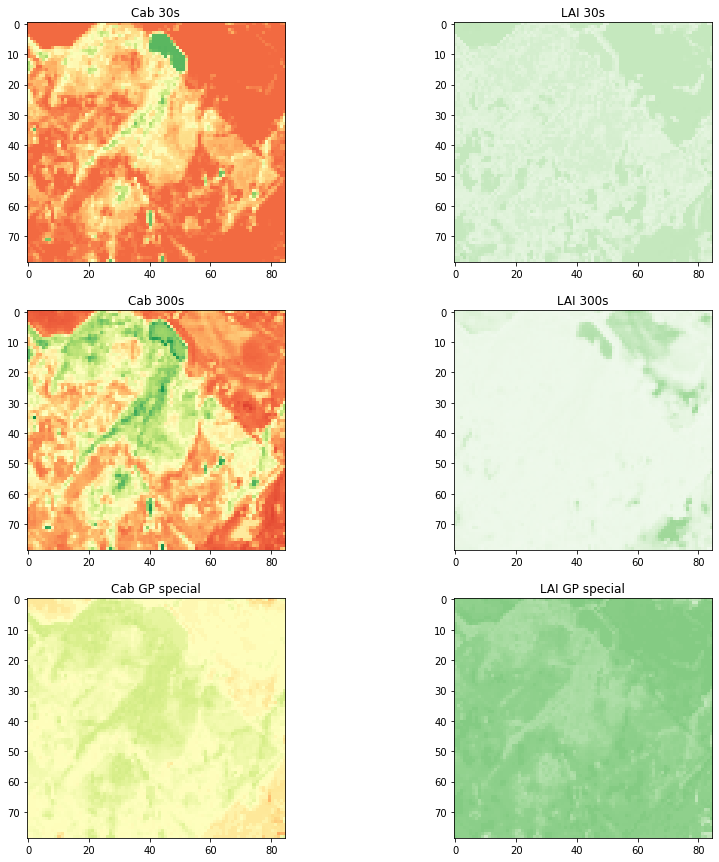

In [16]:
#setting max
cab_min = 5
cab_max = 90
lai_min = 0.5
lai_max = 8
#color map settings
cab_cmap = 'RdYlGn'
lai_cmap = 'Greens'


fig, axs = plt.subplots(3, 2,figsize=(15,15))

axs[0, 0].imshow(rst_cab_0030,vmin=cab_min, vmax=cab_max,cmap=cab_cmap)
axs[0, 0].set_title('Cab 30s')
axs[0, 1].imshow(rst_lai_0030,vmin=lai_min, vmax=lai_max,cmap=lai_cmap)
axs[0, 1].set_title('LAI 30s')
fig.subplots_adjust(right=0.85)

axs[1, 0].imshow(rst_cab_0300,vmin=cab_min, vmax=cab_max,cmap=cab_cmap)
axs[1, 0].set_title('Cab 300s')
axs[1, 1].imshow(rst_lai_0300,vmin=lai_min, vmax=lai_max,cmap=lai_cmap)
axs[1, 1].set_title('LAI 300s')
fig.subplots_adjust(right=0.85)

axs[2, 0].imshow(rst_cab_rest,vmin=cab_min, vmax=cab_max,cmap=cab_cmap)
axs[2, 0].set_title('Cab GP special')
axs[2, 1].imshow(rst_lai_rest,vmin=lai_min, vmax=lai_max,cmap=lai_cmap)
axs[2, 1].set_title('LAI GP special')
fig.subplots_adjust(right=0.85)


### Saving as GeoTiff

- feel free to do a quick exploration 

In [17]:
raster.export(rst_cab_0030, ds1, '/content/drive/MyDrive/SENSECO/Cab_0030_test.tif',dtype='float')
raster.export(rst_lai_0030, ds1, '/content/drive/MyDrive/SENSECO/LAI_0030_test.tif',dtype='float')

raster.export(rst_cab_0300, ds1, '/content/drive/MyDrive/SENSECO/Cab_0300_test.tif',dtype='float')
raster.export(rst_lai_0300, ds1, '/content/drive/MyDrive/SENSECO/LAI_0300_test.tif',dtype='float')

raster.export(rst_cab_rest, ds1, '/content/drive/MyDrive/SENSECO/Cab_rest_test.tif',dtype='float')
raster.export(rst_lai_rest, ds1, '/content/drive/MyDrive/SENSECO/LAI_rest_test.tif',dtype='float')

#Step 3: Loop

- Putting the above steps into a loop

In [ ]:

#loading the csv file with the angle properties
df_geoms = pd.read_csv("/content/drive/MyDrive/SENSECO_S2Data/AngleInformation.csv")

#adding a column with part of the name only
df_geoms["NameOnly"]=df_geoms.Imagename.str[:19]

#create an object with the paths to files
path2files = glob("/content/drive/MyDrive/SENSECO_S2Data/*.tif")

#an object to store an output path
outpath = "/content/drive/MyDrive/SENSECO/Outputs/Rasters/"

for i in range(len(path2files)):

  #print(i)
  temp_path = path2files[i]

  #adapt this this if you change your path to the files, it should return: e.g. S2B_MSIL2A_20190105
  temp_name = temp_path[38:57]

  print("Processing: " + temp_name + " " +  str(i) +"/" + str(len(path2files)))

  #selecting the row of interest in the dataframe
  temp_df_sel = df_geoms[df_geoms["NameOnly"]==temp_name]

  #opening the raster
  ds1, bands = raster.read(temp_path)

  #Preparing spectral data:
  bandByPixel = changeDimension(bands)/10000. #we have to devide all values by 10000 - https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR
  bandByPixel_t = np.transpose(bandByPixel)
  pd_bandByPixel = pd.DataFrame(data=bandByPixel,columns=['B02','B03','B04',
                                                          'B05','B06','B07',
                                                          'B8A','B11','B12'])

  #Preparing the sensor data
  np_sun_zen = np.repeat(temp_df_sel['Sol_Zenith'].iloc[0],ds1.RasterXSize*ds1.RasterYSize)
  np_sen_zen = np.repeat(temp_df_sel['Sen_Zenith'].iloc[0],ds1.RasterXSize*ds1.RasterYSize)
  np_rel_azi = np.repeat(temp_df_sel['Sen_Azimuth'].iloc[0]-temp_df_sel['Sol_Azimuth'].iloc[0],ds1.RasterXSize*ds1.RasterYSize)

  geom_stack = np.stack((np_sun_zen,np_sen_zen,np_rel_azi),axis=1)
  pd_geomByPixel = pd.DataFrame(data=geom_stack,columns=["sol_zen","inc_zen","raa"])

  #putting it togeteher
  pd_Combined = pd.concat([pd_geomByPixel, pd_bandByPixel], axis=1)
 
  #Finally predictions:
  AutoRTM_0030_pred = AutoRTM_0030.predict(pd_Combined )
  AutoRTM_0300_pred = AutoRTM_0300.predict(pd_Combined )
  AutoRTM_rest_pred = AutoRTM_rest.predict(pd_Combined )  

  #Reconstructing the rasters and saving
  AutoRTM_0030_pred_cab = AutoRTM_0030_pred[:,0]
  AutoRTM_0030_pred_lai = AutoRTM_0030_pred[:,1]

  AutoRTM_0300_pred_cab = AutoRTM_0300_pred[:,0]
  AutoRTM_0300_pred_lai = AutoRTM_0300_pred[:,1]

  AutoRTM_rest_pred_cab = AutoRTM_rest_pred[:,0]
  AutoRTM_rest_pred_lai = AutoRTM_rest_pred[:,1]

  #and then we can start the reshape back again using the raster information:
  rst_cab_0030 = np.reshape(AutoRTM_0030_pred_cab,(ds1.RasterYSize,ds1.RasterXSize))
  rst_lai_0030 = np.reshape(AutoRTM_0030_pred_lai,(ds1.RasterYSize,ds1.RasterXSize))

  rst_cab_0300 = np.reshape(AutoRTM_0300_pred_cab,(ds1.RasterYSize,ds1.RasterXSize))
  rst_lai_0300 = np.reshape(AutoRTM_0300_pred_lai,(ds1.RasterYSize,ds1.RasterXSize))

  rst_cab_rest = np.reshape(AutoRTM_rest_pred_cab,(ds1.RasterYSize,ds1.RasterXSize))
  rst_lai_rest = np.reshape(AutoRTM_rest_pred_lai,(ds1.RasterYSize,ds1.RasterXSize))

  #storing the rasters
  raster.export(rst_cab_0030, ds1, outpath + temp_name + "_0030_Cab.tif",dtype='float')
  raster.export(rst_lai_0030, ds1, outpath + temp_name + "_0030_LAI.tif",dtype='float')

  raster.export(rst_cab_0300, ds1, outpath + temp_name + "_0300_Cab.tif",dtype='float')
  raster.export(rst_lai_0300, ds1, outpath + temp_name + "_0300_LAI.tif",dtype='float')

  raster.export(rst_cab_rest, ds1, outpath + temp_name + "_rest_Cab.tif",dtype='float')
  raster.export(rst_lai_rest, ds1, outpath + temp_name + "_rest_LAI.tif",dtype='float')



  